### Agentic RAG

Agentic RAG (Retrieval-Augmented Generation) workflow that automatically:

1️⃣ retrieves information,

2️⃣ checks if it’s relevant,

3️⃣ rewrites the query if not, and

4️⃣ finally generates the correct answer.

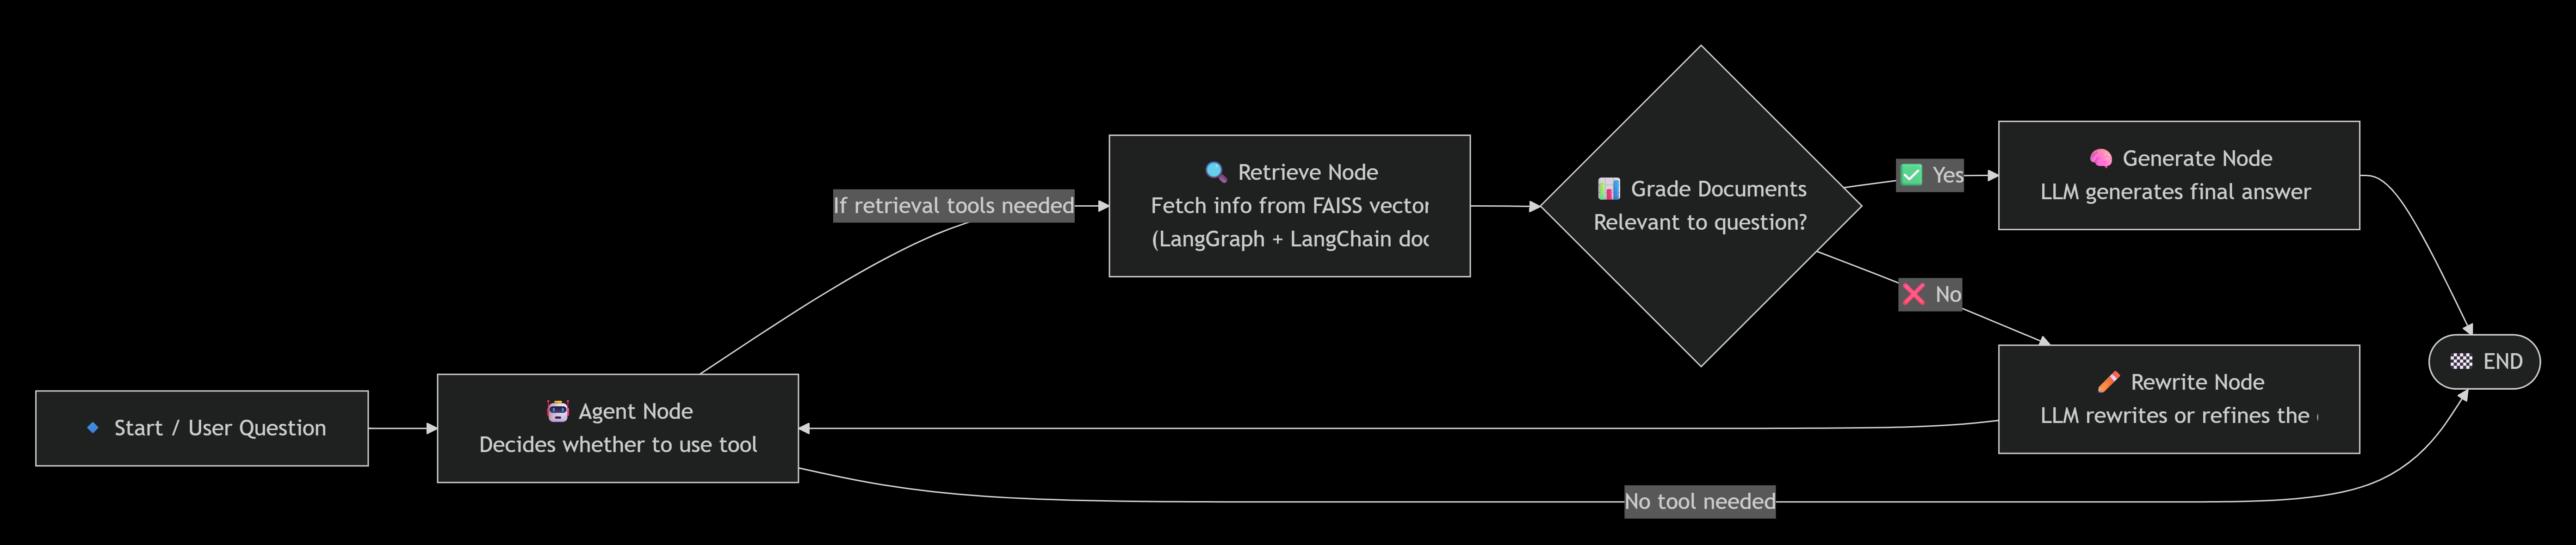

## 1️⃣ Environment Setup

Loads API keys from .env

Sets up Groq (LLM) and OpenAI (Embeddings)

Prepares LangGraph & LangChain docs from the web

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

## 2️⃣ Document Loading + Splitting
Uses WebBaseLoader() to fetch webpage data

Splits text into smaller chunks (1000 tokens each) with overlap 100 for better retrieval

Stores them into FAISS vector databases

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs


[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Learn the basics', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nLearn the basics\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\nJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Learn the basics\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n\n\n          \n  \n    \n  \n  LangGraph\n\n        \n\n\n\n          \n  \n    \n  \n  Agents\n\n        \n\n\n\n          \n  \n    \n  \n  Reference\n\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    Lan

In [4]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)


retriever=vectorstore.as_retriever()

In [5]:
retriever.invoke("what is langgraph")

[Document(id='e52227a9-2e0f-4ac0-a162-b92978a3625d', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Learn the basics', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content="5. Integration:\n   LangGraph works in conjunction with LangSmith, another tool by LangChain, to provide an out-of-the-box solution for building complex, production-ready features with LLMs.\n\n6. Significance:\n   LangGraph is described as setting the foundation for building and scaling AI workloads. It's positioned as a key tool in the next chapter of LLM-based application development, particularly in the realm of agentic AI.\n\n7. Availability:\n   LangGraph is open-source and available on GitHub, which suggests that developers can access and contribute to its codebase.\n\n8. Comparison to Other Frameworks:\n   LangGraph is noted to offer unique benefits compared to other LLM frameworks, particularly in 

### 3️⃣ Retriever Tools

Creates two retrievers:

retriever_tool → for LangGraph docs

retriever_tool_langchain → for LangChain docs

Both wrapped as tools that the agent can call when needed

In [6]:
### Retriever To Retriever Tools
from langchain.tools.retriever import create_retriever_tool
retriever_tool=create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)

In [7]:
retriever_tool

Tool(name='retriever_vector_db_blog', description='Search and run information about Langgraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x0000023E1E1D6200>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000023E20E78F20>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x0000023E1E2E0B80>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000023E20E78F20>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), 

### Langchain Blogs- Seperate Vector Store


In [8]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs=[WebBaseLoader(url).load() for url in langchain_urls]
docs

[[Document(metadata={'source': 'https://python.langchain.com/docs/tutorials/', 'title': 'Tutorials | 🦜️🔗 LangChain', 'description': 'New to LangChain or LLM app development in general? Read this material to quickly get up and running building your first applications.', 'language': 'en'}, page_content='\n\n\n\n\nTutorials | 🦜️🔗 LangChain\n\n\n\n\n\n\nSkip to main contentJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!IntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engineBuild a Question/Answering system over SQL d

In [9]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstorelangchain=FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)


retrieverlangchain=vectorstorelangchain.as_retriever()

In [10]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool_langchain=create_retriever_tool(
    retrieverlangchain,
    "retriever_vector_langchain_blog",
    "Search and run information about Langchain"
)

In [11]:
tools=[retriever_tool,retriever_tool_langchain]

### LangGraph Workflow

### 4️⃣ Define Agent State

- AgentState holds all conversation messages
- Uses LangGraph’s add_messages to append new messages during workflow

In [12]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [14]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")
llm.invoke("Hi")

AIMessage(content='\n<think>\nOkay, the user said "Hi". I should respond in a friendly way. Maybe ask how I can assist them today. Keep it simple and open-ended so they feel comfortable to ask anything. Let me make sure my response is polite and welcoming. Alright, something like "Hello! How can I assist you today?" That should work.\n\nWait, maybe add an emoji to make it a bit warmer? Like a smiley face? Hmm, but should I use emojis? The user didn\'t use any, so maybe keep it neutral. Or maybe a simple one like a smiley without being too casual. Alternatively, just keep it straightforward. Yeah, better to stay professional but friendly. So "Hello! How can I assist you today?" Perfect.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 165, 'prompt_tokens': 11, 'total_tokens': 176, 'completion_time': 0.410010508, 'prompt_time': 0.004955523, 'queue_time': 0.57428176, 'total_time': 0.414966031}, 'model_name': 

##  5️⃣ Agent Node

LLM (ChatGroq) acts as the decision-maker

It reads messages and decides:

Should I call a tool (retriever)?

Or end the process directly?

If tools are used, retrieved data is appended to the message history

In [15]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="qwen-qwq-32b")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

## 6️⃣ Grade Documents (Decision Node)
Another LLM checks if retrieved docs are relevant to the query

Returns either "generate" or "rewrite"

In [16]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

In [17]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="qwen-qwq-32b")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

## 7️⃣ Generate Node

Uses a prebuilt RAG prompt (from LangChain Hub)

Generates the final answer from the retrieved content

Output → final AI response

In [18]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="qwen-qwq-32b")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

## 8️⃣ Rewrite Node

If retrieved docs were irrelevant, the agent rephrases the query

Then the workflow loops back to the agent node

Process repeats until relevant docs are found

In [19]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="qwen-qwq-32b")
    response = model.invoke(msg)
    return {"messages": [response]}

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool,retriever_tool_langchain])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [24]:
graph.invoke({"messages":"What is Langgraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langgraph?', additional_kwargs={}, response_metadata={}, id='b2a31436-0444-4354-8141-31dd21472adb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zhf3', 'function': {'arguments': '{"query": "What is Langgraph?"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 204, 'prompt_tokens': 244, 'total_tokens': 448, 'completion_time': 0.483334386, 'prompt_time': 0.013457998, 'queue_time': 1.754585895, 'total_time': 0.496792384}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_fbb7e6cc39', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-30a9d76a-cb1c-4006-b550-0c71cab02688-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'What is Langgraph?'}, 'id': 'call_zhf3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 244, 'output_tokens': 204, 'total_tokens': 448}),
  ToolMessage(content='5. Integration:\n   LangGraph wo

In [27]:
graph.invoke({"messages":"What is Langchain?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langchain?', additional_kwargs={}, response_metadata={}, id='b59cf3d6-8a02-4fd0-b641-738c811a4d66'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sex2', 'function': {'arguments': '{"query": "What is Langchain?"}', 'name': 'retriever_vector_langchain_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 186, 'prompt_tokens': 244, 'total_tokens': 430, 'completion_time': 0.461619046, 'prompt_time': 0.032314096, 'queue_time': 0.500323847, 'total_time': 0.493933142}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_3796682456', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7ac5a7b9-74fd-4c79-bc87-609019def050-0', tool_calls=[{'name': 'retriever_vector_langchain_blog', 'args': {'query': 'What is Langchain?'}, 'id': 'call_sex2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 244, 'output_tokens': 186, 'total_tokens': 430}),
  ToolMessage(content="Tutorials | 🦜️🔗 La

In [28]:
graph.invoke({"messages":"What is Machine learning?"})

---CALL AGENT---


{'messages': [HumanMessage(content='What is Machine learning?', additional_kwargs={}, response_metadata={}, id='4e92fdbc-f8e4-4411-927c-837a4cea5b6b'),
  AIMessage(content='Machine learning is a subset of artificial intelligence (AI) that focuses on developing algorithms and statistical models. These allow systems to improve at tasks through experience, typically by learning patterns from data, rather than relying solely on explicit programming.\n\n### Key Aspects:\n1. **Data-Driven**: Systems learn from historical data to make predictions or decisions.\n2. **Types of Learning**:\n   - **Supervised Learning**: Uses labeled data (e.g., predicting house prices based on features like size or location).\n   - **Unsupervised Learning**: Finds hidden patterns in unlabeled data (e.g., customer segmentation).\n   - **Reinforcement Learning**: Learns by trial-and-error via rewards/penalties (e.g., game-playing AI).\n\n### Common Applications:\n- Image/speech recognition\n- Recommendation system